In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/project/tomatoAll.zip /content
!unzip /content/tomatoAll.zip

Streaming output truncated to the last 5000 lines.
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25592188-309d-450c-b45f-fbbdb02b316f___Matt.S_CG 6181.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/2567c820-aa63-490c-8e47-921b85164728___Matt.S_CG 7447.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/256b92d9-41f3-47a4-870f-c0c0f0ac201e___Matt.S_CG 6842.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25b6cc2a-d883-4e3f-9caa-738e5ec35e30___JR_Sept.L.S 8465.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25c45a05-4f45-42ad-b18a-b7f694023a31___Matt.S_CG 0824.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/25f7a39f-7fef-4f5d-af4f-cf21934f516a___JR_Sept.L.S 2493.JPG  
 extracting: tomatoAll/plant-village/Tomato Septoria leaf spot/261666dc-32fb-43b2-93

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/tomatoAll/'
expert_path = '/content/tomatoAll/plan-diseases-expert'
village_path = '/content/tomatoAll/plant-village'
internet_path = '/content/drive/MyDrive/Colab Notebooks/tomato_images2/'


BATCH_SIZE = 256
IMG_SIZE = (75, 75)
SEED = 42

In [3]:
train_gen, test_gen = tf.keras.utils.image_dataset_from_directory(
    village_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


VALIDATION_SPLIT = 0.15

train_gen = train_gen.take(int((1 - VALIDATION_SPLIT) * len(train_gen)))
valid_gen = train_gen.skip(int((1 - VALIDATION_SPLIT) * len(train_gen)))

valid2_gen, test2_gen = tf.keras.utils.image_dataset_from_directory(
    expert_path,
    seed=SEED,
    validation_split=0.5,
    image_size=IMG_SIZE,
    subset="both",
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


test3_gen = tf.keras.utils.image_dataset_from_directory(
    internet_path,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid2_gen = valid2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test2_gen = test2_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test3_gen = test3_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid3_gen = test3_gen

Found 12803 files belonging to 9 classes.
Using 10883 files for training.
Using 1920 files for validation.
Found 37455 files belonging to 9 classes.
Using 18728 files for training.
Using 18727 files for validation.
Found 35 files belonging to 9 classes.


In [37]:
from tensorflow.keras.applications import DenseNet121, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import matplotlib.pyplot as plt

In [6]:
class TripleValidationCallback(Callback):
    def __init__(self, validation_gen2, validation_gen3):
        super().__init__()
        self.validation_gen2 = validation_gen2
        self.validation_gen3 = validation_gen3
        self.history = {'val2_loss': [], 'val2_acc': [], 'val3_loss': [], 'val3_acc': []}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss2, val_acc2 = self.model.evaluate(self.validation_gen2, verbose=0)
        val_loss3, val_acc3 = self.model.evaluate(self.validation_gen3, verbose=0)
        logs['val2_loss'] = val_loss2
        logs['val2_acc'] = val_acc2
        logs['val3_loss'] = val_loss3
        logs['val3_acc'] = val_acc3
        self.history['val2_loss'].append(val_loss2)
        self.history['val2_acc'].append(val_acc2)
        self.history['val3_loss'].append(val_loss3)
        self.history['val3_acc'].append(val_acc3)


In [36]:
def create_and_train_model(base_model, model_filename, freeze_layers=True, epoch=50):

    # Freeze layers
    if freeze_layers:
      for layer in base_model.layers:
          layer.trainable = False

    # GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Modify pre-trained model
    output = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val2_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

    # Define ModelCheckpoint callback
    # model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', mode='min', save_best_only=True)

    triple_val_callback = TripleValidationCallback(validation_gen2=valid2_gen, validation_gen3=valid3_gen)

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=epoch, callbacks=[triple_val_callback, early_stopping])

    # Combine Keras history with custom callback history
    history = history.history
    history.update(triple_val_callback.history)

    # # Save the model
    model.save(model_filename)

    # Plotting Losses
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation1 Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    # Plotting Losses
    plt.figure()
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation1 Loss')
    plt.plot(history['val2_loss'], label='Validation2 Loss')
    plt.plot(history['val3_loss'], label='Validation3 Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracies
    plt.figure()
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation1 Accuracy')
    plt.plot(history['val2_acc'], label='Validation2 Accuracy')
    plt.plot(history['val3_acc'], label='Validation3 Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Measure inference time 2
    start_time = time.time()
    _, accuracy2 = model.evaluate(test2_gen)
    end_time = time.time()
    inference_time2 = end_time - start_time

    # Measure inference time 3
    start_time = time.time()
    _, accuracy3 = model.evaluate(test3_gen)
    end_time = time.time()
    inference_time3 = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    # Print results
    print(f"Model: {model_filename}")
    print(f"Params: {num_params}")
    print(f"Inference Time: {inference_time}")
    print(f"Accuracy: {accuracy}")
    print(f"Inference Time2: {inference_time2}")
    print(f"Accuracy2: {accuracy2}")
    print(f"Inference Time3: {inference_time3}")
    print(f"Accuracy3: {accuracy3}")



29084464/29084464 [==============================] - 3s 0us/step
Epoch 1/50
36/36 [==============================] - 84s 384ms/step - loss: 0.6130 - accuracy: 0.8112 - val_loss: 6.3354 - val_accuracy: 0.4779 - val2_loss: 6.4834 - val2_acc: 0.4385 - val3_loss: 24.0730 - val3_acc: 0.0571
Epoch 2/50
36/36 [==============================] - 6s 161ms/step - loss: 0.1051 - accuracy: 0.9647 - val_loss: 5.5938 - val_accuracy: 0.5085 - val2_loss: 6.6003 - val2_acc: 0.4332 - val3_loss: 13.3855 - val3_acc: 0.1714
Epoch 3/50
36/36 [==============================] - 6s 162ms/step - loss: 0.0409 - accuracy: 0.9850 - val_loss: 3.9467 - val_accuracy: 0.5658 - val2_loss: 5.0801 - val2_acc: 0.4655 - val3_loss: 13.3524 - val3_acc: 0.1714
Epoch 4/50
36/36 [==============================] - 6s 162ms/step - loss: 0.0252 - accuracy: 0.9920 - val_loss: 0.2612 - val_accuracy: 0.9362 - val2_loss: 1.0557 - val2_acc: 0.8188 - val3_loss: 7.5590 - val3_acc: 0.3429
Epoch 5/50
36/36 [==============================] -

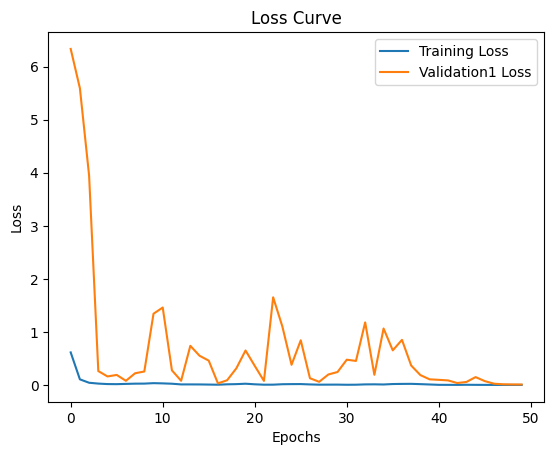

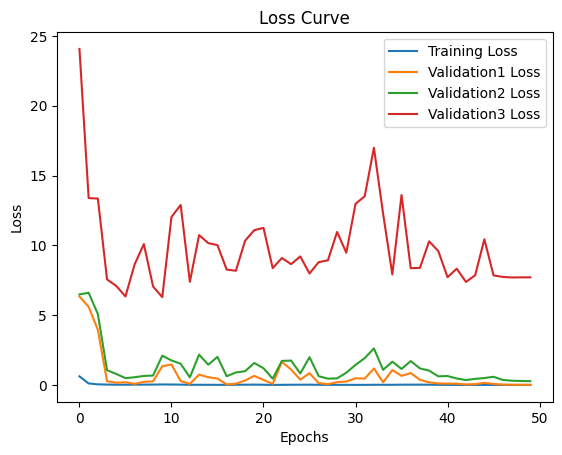

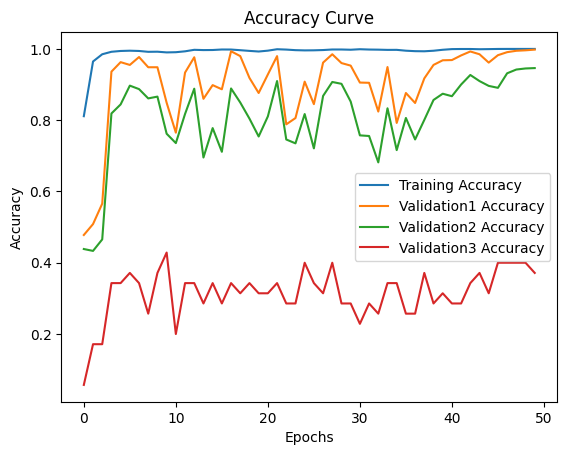

1/1 [==============================] - 0s 27ms/step - loss: 7.7085 - accuracy: 0.3714
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_50e_drop3.model
Params: 7046729
Inference Time: 0.48404550552368164
Accuracy: 0.9901041388511658
Inference Time2: 2.553528308868408
Accuracy2: 0.9493778944015503
Inference Time3: 0.039270877838134766
Accuracy3: 0.37142857909202576


In [8]:
# Create and train DenseNet121 75 256 drop3
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_50e_drop3.model', freeze_layers=False)

Epoch 1/100
36/36 [==============================] - 63s 232ms/step - loss: 0.6154 - accuracy: 0.8104 - val_loss: 10.6517 - val_accuracy: 0.3438 - val2_loss: 16.7518 - val2_acc: 0.3094 - val3_loss: 37.0842 - val3_acc: 0.1429
Epoch 2/100
36/36 [==============================] - 6s 168ms/step - loss: 0.0772 - accuracy: 0.9731 - val_loss: 3.4372 - val_accuracy: 0.5996 - val2_loss: 5.0863 - val2_acc: 0.5152 - val3_loss: 13.9981 - val3_acc: 0.2000
Epoch 3/100
36/36 [==============================] - 6s 167ms/step - loss: 0.0330 - accuracy: 0.9895 - val_loss: 1.1466 - val_accuracy: 0.7865 - val2_loss: 2.2324 - val2_acc: 0.6728 - val3_loss: 9.7316 - val3_acc: 0.2571
Epoch 4/100
36/36 [==============================] - 6s 169ms/step - loss: 0.0296 - accuracy: 0.9907 - val_loss: 0.7048 - val_accuracy: 0.8802 - val2_loss: 1.1933 - val2_acc: 0.7945 - val3_loss: 9.1827 - val3_acc: 0.3143
Epoch 5/100
36/36 [==============================] - 6s 169ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss

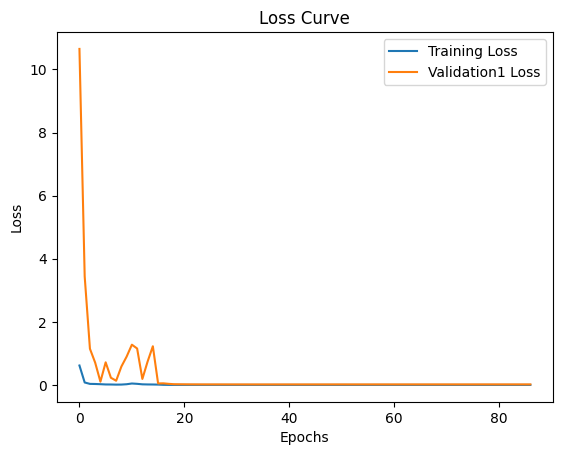

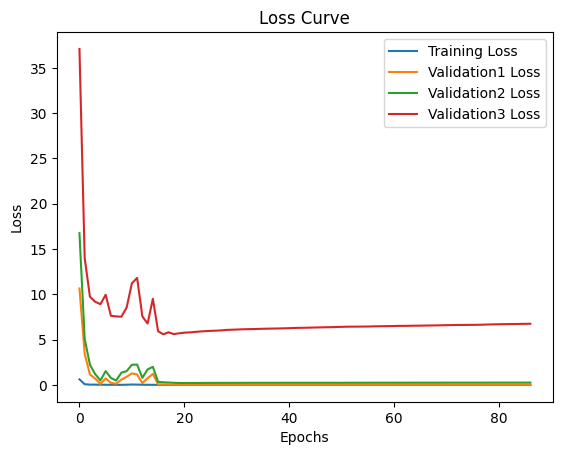

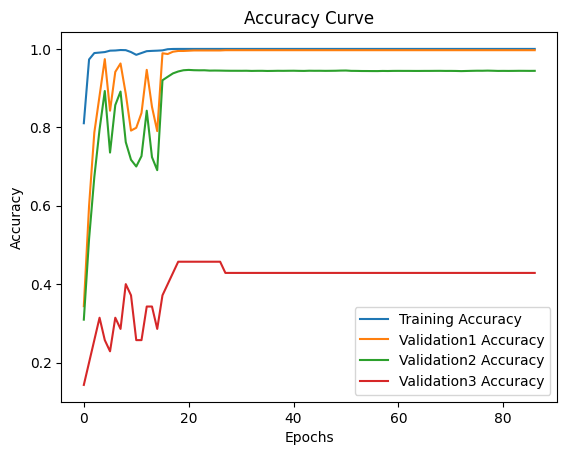

1/1 [==============================] - 0s 27ms/step - loss: 6.2090 - accuracy: 0.4286
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_drop3.model
Params: 7046729
Inference Time: 0.27936339378356934
Accuracy: 0.9880208373069763
Inference Time2: 2.2163991928100586
Accuracy2: 0.9471351504325867
Inference Time3: 0.04149055480957031
Accuracy3: 0.4285714328289032


In [19]:
# Create and train DenseNet121 75 256 drop3
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_drop3.model', freeze_layers=False, epoch=100)

Epoch 1/100
36/36 [==============================] - 63s 234ms/step - loss: 0.7704 - accuracy: 0.7752 - val_loss: 15.6432 - val_accuracy: 0.4232 - val2_loss: 17.0182 - val2_acc: 0.3692 - val3_loss: 39.5897 - val3_acc: 0.0571
Epoch 2/100
36/36 [==============================] - 6s 170ms/step - loss: 0.1226 - accuracy: 0.9578 - val_loss: 12.0294 - val_accuracy: 0.3971 - val2_loss: 13.9009 - val2_acc: 0.3636 - val3_loss: 50.0528 - val3_acc: 0.1143
Epoch 3/100
36/36 [==============================] - 6s 172ms/step - loss: 0.0506 - accuracy: 0.9846 - val_loss: 2.5847 - val_accuracy: 0.6654 - val2_loss: 3.2407 - val2_acc: 0.5893 - val3_loss: 10.1244 - val3_acc: 0.1429
Epoch 4/100
36/36 [==============================] - 6s 168ms/step - loss: 0.0380 - accuracy: 0.9877 - val_loss: 3.6253 - val_accuracy: 0.6217 - val2_loss: 4.7743 - val2_acc: 0.5314 - val3_loss: 12.9386 - val3_acc: 0.1714
Epoch 5/100
36/36 [==============================] - 6s 170ms/step - loss: 0.0348 - accuracy: 0.9889 - val_

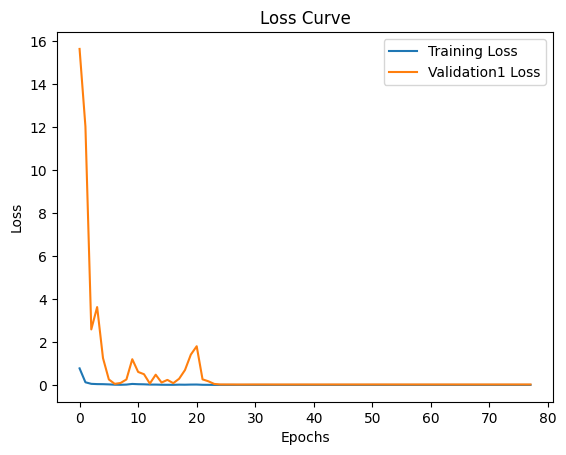

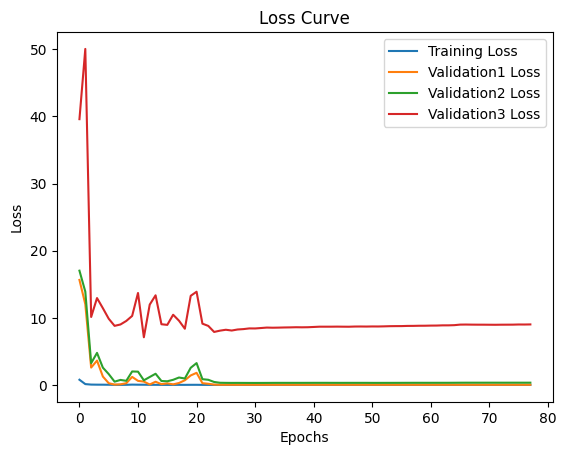

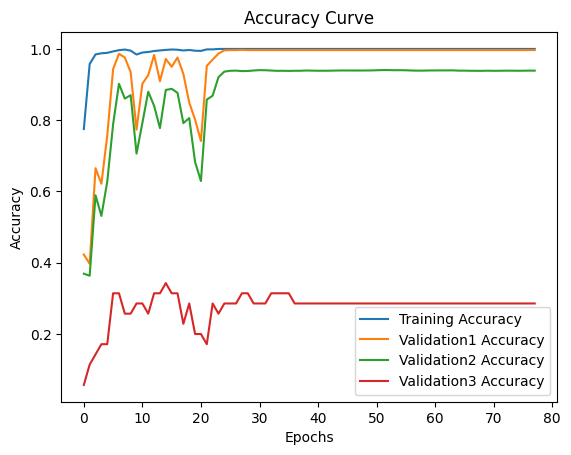

1/1 [==============================] - 0s 28ms/step - loss: 8.2569 - accuracy: 0.3143
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_drop5.model
Params: 7046729
Inference Time: 0.27588415145874023
Accuracy: 0.9885416626930237
Inference Time2: 2.2320806980133057
Accuracy2: 0.940139889717102
Inference Time3: 0.04106283187866211
Accuracy3: 0.3142857253551483


In [21]:
# Create and train DenseNet121 75 256 drop5
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_drop5.model', freeze_layers=False, epoch=100)

Epoch 1/100
36/36 [==============================] - 69s 243ms/step - loss: 0.5464 - accuracy: 0.8317 - val_loss: 7.5145 - val_accuracy: 0.5052 - val2_loss: 7.9100 - val2_acc: 0.4625 - val3_loss: 13.7322 - val3_acc: 0.1429
Epoch 2/100
36/36 [==============================] - 6s 173ms/step - loss: 0.0852 - accuracy: 0.9717 - val_loss: 3.5132 - val_accuracy: 0.6159 - val2_loss: 3.9700 - val2_acc: 0.5634 - val3_loss: 10.0763 - val3_acc: 0.2286
Epoch 3/100
36/36 [==============================] - 6s 171ms/step - loss: 0.0282 - accuracy: 0.9906 - val_loss: 1.9717 - val_accuracy: 0.7253 - val2_loss: 2.3550 - val2_acc: 0.6589 - val3_loss: 12.3019 - val3_acc: 0.2000
Epoch 4/100
36/36 [==============================] - 6s 171ms/step - loss: 0.0130 - accuracy: 0.9964 - val_loss: 1.1330 - val_accuracy: 0.8190 - val2_loss: 1.4682 - val2_acc: 0.7564 - val3_loss: 8.7299 - val3_acc: 0.2286
Epoch 5/100
36/36 [==============================] - 6s 171ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss:

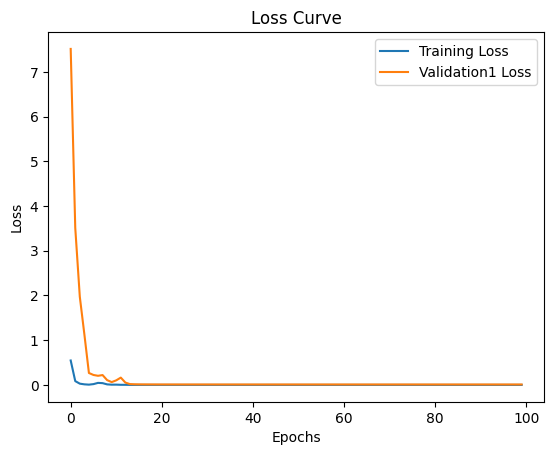

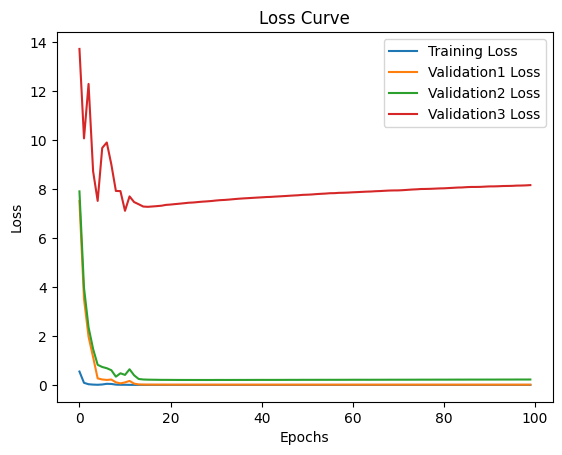

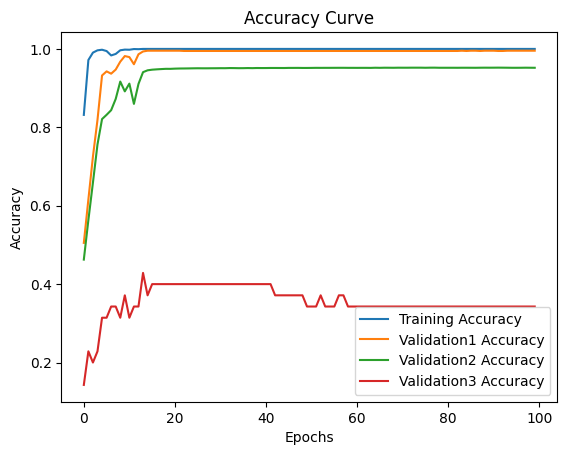

1/1 [==============================] - 0s 31ms/step - loss: 8.1660 - accuracy: 0.3429
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_drop1.model
Params: 7046729
Inference Time: 0.28176021575927734
Accuracy: 0.9895833134651184
Inference Time2: 2.2708401679992676
Accuracy2: 0.9531692266464233
Inference Time3: 0.04284310340881348
Accuracy3: 0.34285715222358704


In [23]:
# Create and train DenseNet121 75 256 drop1
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_drop1.model', freeze_layers=False, epoch=100)

Epoch 1/100
36/36 [==============================] - 63s 232ms/step - loss: 0.6908 - accuracy: 0.7925 - val_loss: 4.6332 - val_accuracy: 0.4284 - val2_loss: 5.2708 - val2_acc: 0.3817 - val3_loss: 11.7253 - val3_acc: 0.1714
Epoch 2/100
36/36 [==============================] - 6s 167ms/step - loss: 0.1057 - accuracy: 0.9645 - val_loss: 2.7786 - val_accuracy: 0.6940 - val2_loss: 3.1242 - val2_acc: 0.6305 - val3_loss: 9.9972 - val3_acc: 0.2857
Epoch 3/100
36/36 [==============================] - 6s 165ms/step - loss: 0.0539 - accuracy: 0.9794 - val_loss: 1.4314 - val_accuracy: 0.7806 - val2_loss: 1.6801 - val2_acc: 0.7446 - val3_loss: 7.6961 - val3_acc: 0.3429
Epoch 4/100
36/36 [==============================] - 6s 162ms/step - loss: 0.0427 - accuracy: 0.9859 - val_loss: 0.7704 - val_accuracy: 0.8405 - val2_loss: 1.8258 - val2_acc: 0.7202 - val3_loss: 10.4463 - val3_acc: 0.2571
Epoch 5/100
36/36 [==============================] - 6s 163ms/step - loss: 0.0379 - accuracy: 0.9886 - val_loss: 

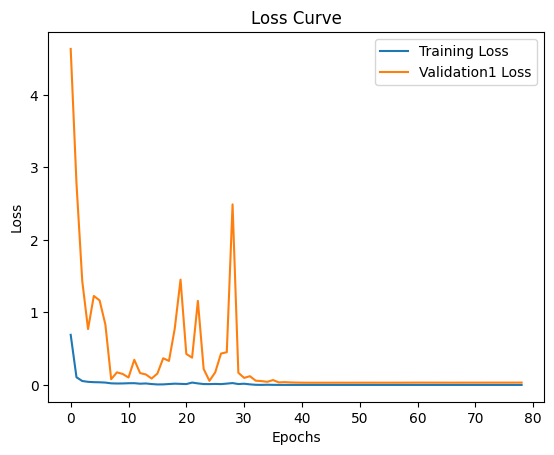

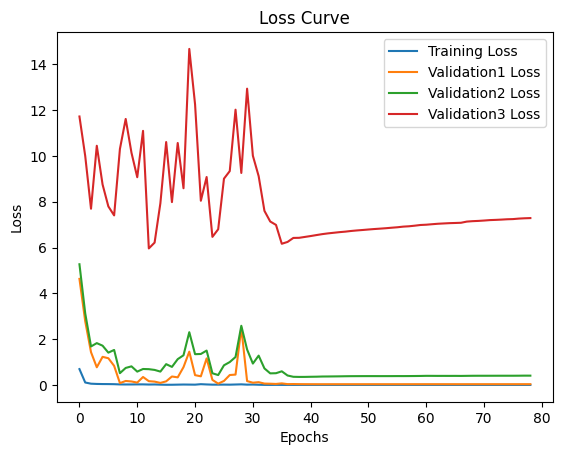

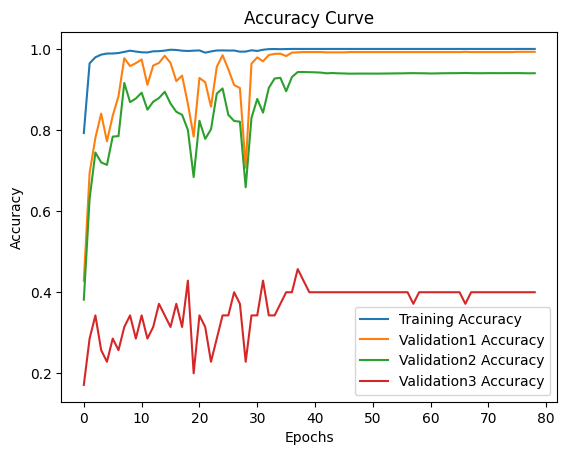

1/1 [==============================] - 0s 28ms/step - loss: 6.4257 - accuracy: 0.4286
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense256d3.model
Params: 7302217
Inference Time: 0.2817394733428955
Accuracy: 0.9895833134651184
Inference Time2: 2.2129909992218018
Accuracy2: 0.9470283389091492
Inference Time3: 0.04106640815734863
Accuracy3: 0.4285714328289032


In [28]:
# Create and train DenseNet121 75 256 dense256 d3
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense256d3.model', freeze_layers=False, epoch=100)

Epoch 1/100
36/36 [==============================] - 65s 242ms/step - loss: 0.8979 - accuracy: 0.7285 - val_loss: 29.9920 - val_accuracy: 0.1491 - val2_loss: 31.0238 - val2_acc: 0.1588 - val3_loss: 64.2143 - val3_acc: 0.1714
Epoch 2/100
36/36 [==============================] - 6s 174ms/step - loss: 0.1693 - accuracy: 0.9456 - val_loss: 2.6955 - val_accuracy: 0.4980 - val2_loss: 3.6210 - val2_acc: 0.4166 - val3_loss: 8.2772 - val3_acc: 0.1714
Epoch 3/100
36/36 [==============================] - 6s 168ms/step - loss: 0.0732 - accuracy: 0.9773 - val_loss: 2.9641 - val_accuracy: 0.6016 - val2_loss: 4.0760 - val2_acc: 0.5062 - val3_loss: 10.1832 - val3_acc: 0.2571
Epoch 4/100
36/36 [==============================] - 6s 169ms/step - loss: 0.0498 - accuracy: 0.9870 - val_loss: 3.3563 - val_accuracy: 0.5996 - val2_loss: 5.2497 - val2_acc: 0.4735 - val3_loss: 12.8384 - val3_acc: 0.1714
Epoch 5/100
36/36 [==============================] - 6s 174ms/step - loss: 0.0382 - accuracy: 0.9884 - val_los

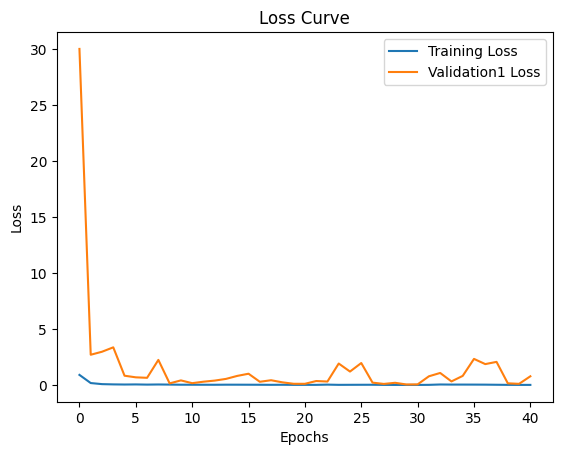

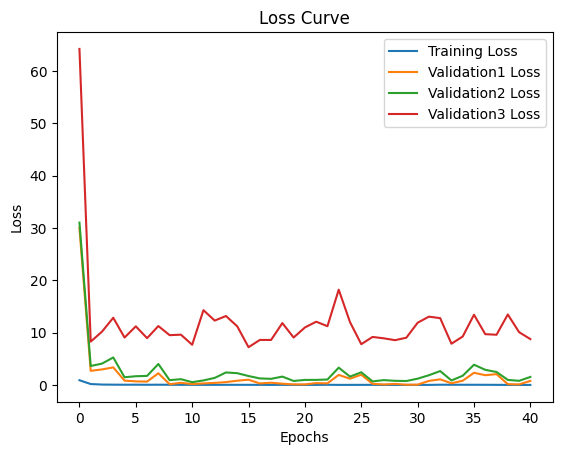

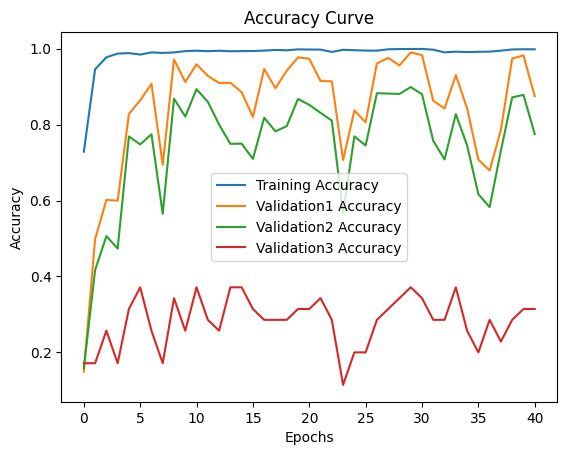

1/1 [==============================] - 0s 29ms/step - loss: 7.6762 - accuracy: 0.3714
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense256d5.model
Params: 7302217
Inference Time: 0.28102779388427734
Accuracy: 0.9463541507720947
Inference Time2: 2.2818405628204346
Accuracy2: 0.8966732621192932
Inference Time3: 0.04264116287231445
Accuracy3: 0.37142857909202576


In [30]:
# Create and train DenseNet121 75 256 dense256 d5
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense256d5.model', freeze_layers=False, epoch=100)

Epoch 1/100
36/36 [==============================] - 64s 239ms/step - loss: 0.6077 - accuracy: 0.8052 - val_loss: 13.3033 - val_accuracy: 0.2559 - val2_loss: 14.8739 - val2_acc: 0.2316 - val3_loss: 25.7198 - val3_acc: 0.2000
Epoch 2/100
36/36 [==============================] - 6s 172ms/step - loss: 0.0894 - accuracy: 0.9695 - val_loss: 5.5363 - val_accuracy: 0.4609 - val2_loss: 6.5210 - val2_acc: 0.3932 - val3_loss: 12.2034 - val3_acc: 0.2000
Epoch 3/100
36/36 [==============================] - 6s 171ms/step - loss: 0.0527 - accuracy: 0.9818 - val_loss: 2.1586 - val_accuracy: 0.7624 - val2_loss: 3.3498 - val2_acc: 0.6608 - val3_loss: 12.5793 - val3_acc: 0.2571
Epoch 4/100
36/36 [==============================] - 6s 172ms/step - loss: 0.0370 - accuracy: 0.9871 - val_loss: 0.7947 - val_accuracy: 0.8464 - val2_loss: 1.7571 - val2_acc: 0.7323 - val3_loss: 7.6151 - val3_acc: 0.2000
Epoch 5/100
36/36 [==============================] - 6s 172ms/step - loss: 0.0164 - accuracy: 0.9949 - val_los

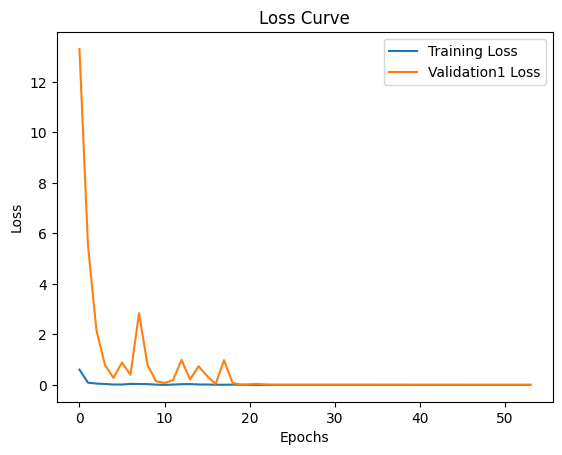

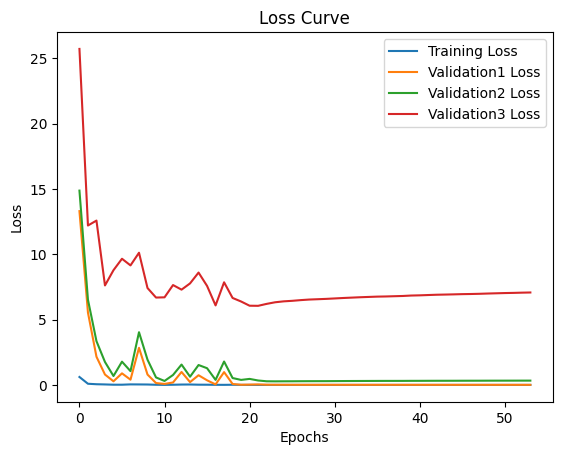

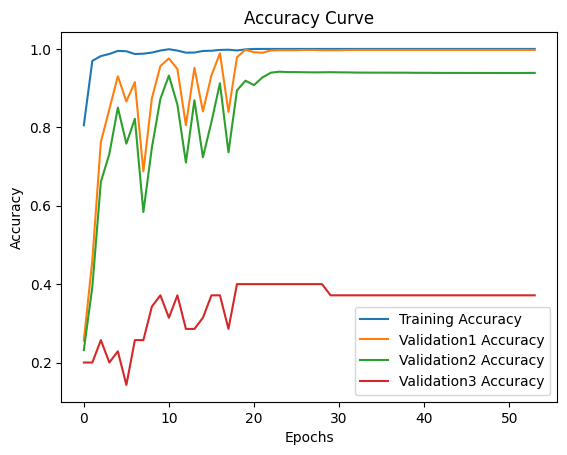

1/1 [==============================] - 0s 28ms/step - loss: 6.3265 - accuracy: 0.4000
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense256d1.model
Params: 7302217
Inference Time: 0.27864813804626465
Accuracy: 0.9921875
Inference Time2: 2.264268398284912
Accuracy2: 0.946601152420044
Inference Time3: 0.04097127914428711
Accuracy3: 0.4000000059604645


In [32]:
# Create and train DenseNet121 75 256 dense256 d1
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense256d1.model', freeze_layers=False, epoch=100)

Epoch 1/100
36/36 [==============================] - 72s 253ms/step - loss: 0.6849 - accuracy: 0.7793 - val_loss: 8.6679 - val_accuracy: 0.3171 - val2_loss: 8.5067 - val2_acc: 0.2957 - val3_loss: 15.7765 - val3_acc: 0.0857
Epoch 2/100
36/36 [==============================] - 6s 174ms/step - loss: 0.1365 - accuracy: 0.9550 - val_loss: 2.5925 - val_accuracy: 0.6009 - val2_loss: 3.4868 - val2_acc: 0.5079 - val3_loss: 13.6559 - val3_acc: 0.1429
Epoch 3/100
36/36 [==============================] - 6s 172ms/step - loss: 0.0536 - accuracy: 0.9813 - val_loss: 4.7707 - val_accuracy: 0.4473 - val2_loss: 5.8954 - val2_acc: 0.3690 - val3_loss: 12.0302 - val3_acc: 0.1143
Epoch 4/100
36/36 [==============================] - 6s 175ms/step - loss: 0.0368 - accuracy: 0.9891 - val_loss: 1.6188 - val_accuracy: 0.7064 - val2_loss: 2.5649 - val2_acc: 0.6083 - val3_loss: 10.6580 - val3_acc: 0.1714
Epoch 5/100
36/36 [==============================] - 6s 175ms/step - loss: 0.0435 - accuracy: 0.9849 - val_loss

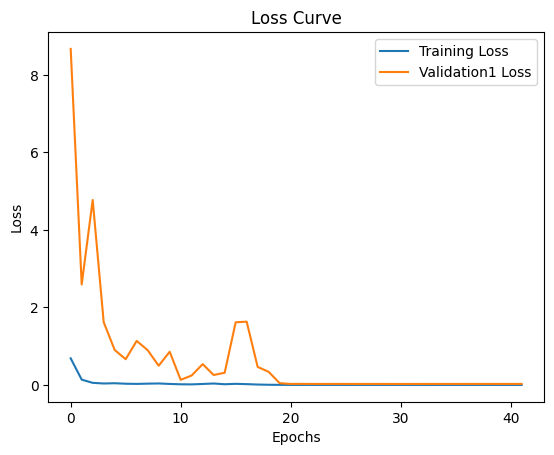

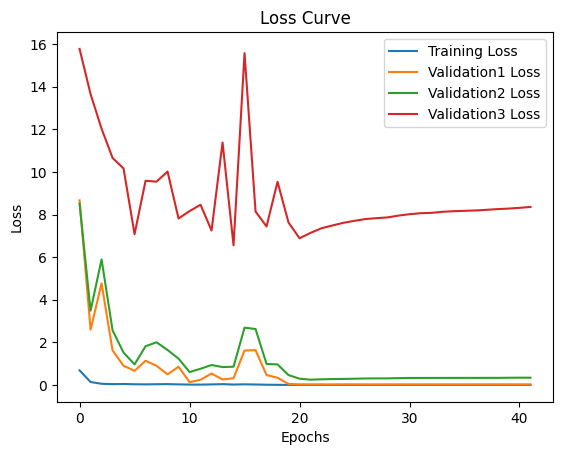

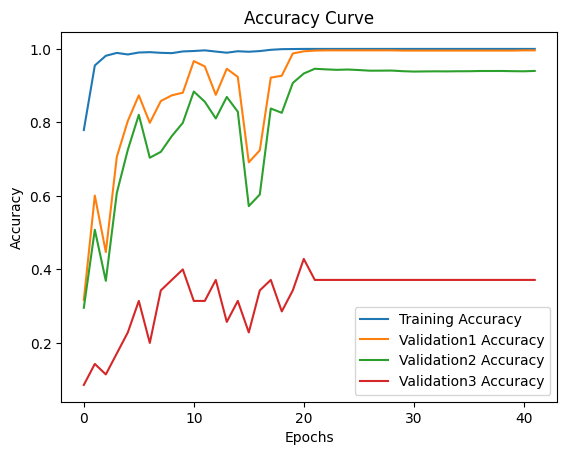

1/1 [==============================] - 0s 29ms/step - loss: 7.1400 - accuracy: 0.3714
Model: /content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense128d3.model
Params: 7169865
Inference Time: 0.29375481605529785
Accuracy: 0.9848958253860474
Inference Time2: 2.299478769302368
Accuracy2: 0.9481497406959534
Inference Time3: 0.04049563407897949
Accuracy3: 0.37142857909202576


In [35]:
# Create and train DenseNet121 75 256 dense128 d3
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/densenet121_tomatoAll_75s_256b_el_dense128d3.model', freeze_layers=False, epoch=100)

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/200
36/36 [==============================] - 29s 121ms/step - loss: 0.6985 - accuracy: 0.7716 - val_loss: 15.3268 - val_accuracy: 0.2383 - val2_loss: 16.4874 - val2_acc: 0.2048 - val3_loss: 19.7733 - val3_acc: 0.0286
Epoch 2/200
36/36 [==============================] - 3s 90ms/step - loss: 0.1583 - accuracy: 0.9486 - val_loss: 18.9532 - val_accuracy: 0.1966 - val2_loss: 19.5885 - val2_acc: 0.1681 - val3_loss: 27.7006 - val3_acc: 0.0286
Epoch 3/200
36/36 [==============================] - 3s 90ms/step - loss: 0.0786 - accuracy: 0.9748 - val_loss: 29.8805 - val_accuracy: 0.1673 - val2_loss: 30.9715 - val2_acc: 0.1433 - val3_loss: 42.3906 - val3_acc: 0.0286
Epoch 4/200
36/36 [==============================] - 3s 89ms/step - loss: 0.0450 - accuracy: 0.9867 - val_loss: 33.3156 - val_accuracy: 0.1745 - val2_loss: 34.3075 - val2_acc: 0.1488 - val3_loss: 39.0550 - val3_acc: 0.0286
Epoch 5/200
36/36 [========================

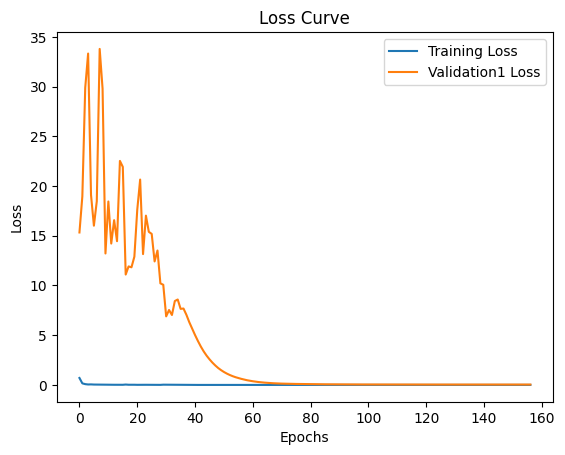

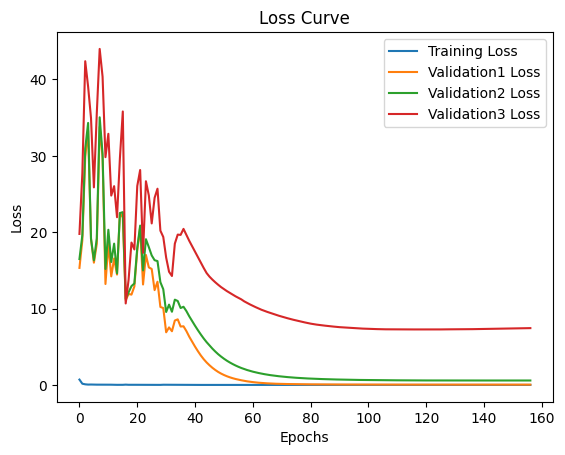

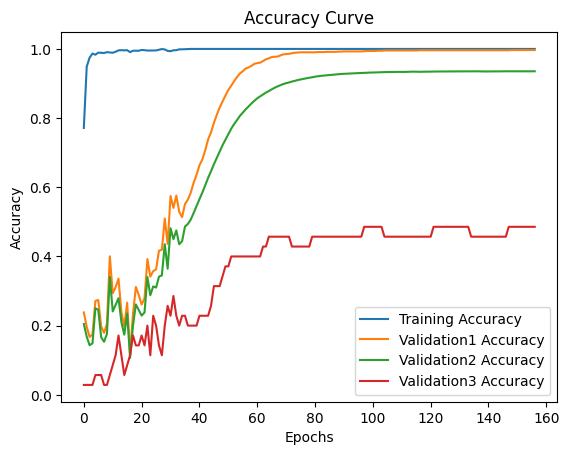

1/1 [==============================] - 0s 17ms/step - loss: 7.3030 - accuracy: 0.4571
Model: /content/drive/MyDrive/Colab Notebooks/MobileNetV2_tomatoAll_75s_256b_el_dense256d3.model
Params: 2588233
Inference Time: 0.16598105430603027
Accuracy: 0.9859374761581421
Inference Time2: 1.249995231628418
Accuracy2: 0.9343194365501404
Inference Time3: 0.023828744888305664
Accuracy3: 0.4571428596973419


In [38]:
# Create and train MobileNetV2 75 256 dense256 d3
densenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
create_and_train_model(densenet_base, '/content/drive/MyDrive/Colab Notebooks/MobileNetV2_tomatoAll_75s_256b_el_dense256d3.model', freeze_layers=False, epoch=200)